In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import ruptures as rpt
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, NoDataAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor, RobustThreshold)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore, 
                                 VIAnomalyScore, SpectralAnomalyScoreExt, MatrixProfileAnomalyScore,
                                 NoDataAnomalyScoreExt, ChangePointDetector, EnsembleAnomalyScore )
import datetime as dt
import pymc3 as pm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
import matplotlib
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-06-25T12:35:45.284 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [3]:
Temperature = 'FLOATVALUE'
spectral = Temperature + '_spectral'
spectralinv = Temperature + '_spectralinv'
signal = Temperature + '_energy'
rob = Temperature + '_rob'
nodata = Temperature + '_nodata'
cpd = Temperature + '_cpd'
cpd_sig = Temperature + '_cpd_sig'
cpd_inv = Temperature + '_cpd_inv_sig'

In [4]:
# deviceid ac2efe94-842d-3679-9f63-2d5365e01a11
# tag path ca3e/sws/ait2107/eu
df1_raw = pd.read_csv('IOT_TAGDATA_TYPE_202106151143_ca3e_sws_ait2107_eu.csv',
                     parse_dates=['RCV_TIMESTAMP_UTC'], infer_datetime_format=True)
df1_raw['RCV_TIMESTAMP_UTC'] = pd.to_datetime(df1_raw['RCV_TIMESTAMP_UTC'], 
                                            format='%Y-%m-%d-%H.%M.%S.%f')
df1_raw = df1_raw.sort_values('RCV_TIMESTAMP_UTC')
df1_i = df1_raw.set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])

In [13]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv, signal)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
spsi._entity_type = et
df1_i = spsi.execute(df=df1_i)

2021-06-23T17:24:00.864 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


In [14]:
rbi1 = RobustThreshold(Temperature, 0.995, rob)
#rbi1.delete_model = True
et = rbi1._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
rbi1._entity_type = et
df1_i = rbi1.execute(df=df1_i)

2021-06-23T17:24:01.647 INFO iotfunctions.anomaly.__init__ RobustThreshold from FLOATVALUE quantile threshold 0.995 exceeding boolean FLOATVALUE_rob
2021-06-23T17:24:01.652 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-06-23T17:24:01.680 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_ROBUSTTHRESHOLD.SupervisedLearningTransformer.FLOATVALUE_rob.ac2efe94-842d-3679-9f63-2d5365e01a11 of size 652563 bytes has been retrieved from filesystem
2021-06-23T17:24:01.681 INFO iotfunctions.anomaly.load_model load model <iotfunctions.anomaly.KDEMaxMin object at 0x7f19b097fa60>


In [7]:
cpdi1 = ChangePointDetector(Temperature, cpd)
#rbi1.delete_model = True
et = cpdi1._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
cpdi1._entity_type = et
df1_i = cpdi1.execute(df=df1_i)

2021-06-23T12:08:46.511 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
0 [1474, 1530, 2072, 6170, 7284, 8048, 8066, 14402, 19756, 25076, 28012, 29916, 30434, 32584, 32596, 37645]


In [8]:
df1 = df1_i.reset_index()

Text(0.5, 1.0, 'Signal energy')

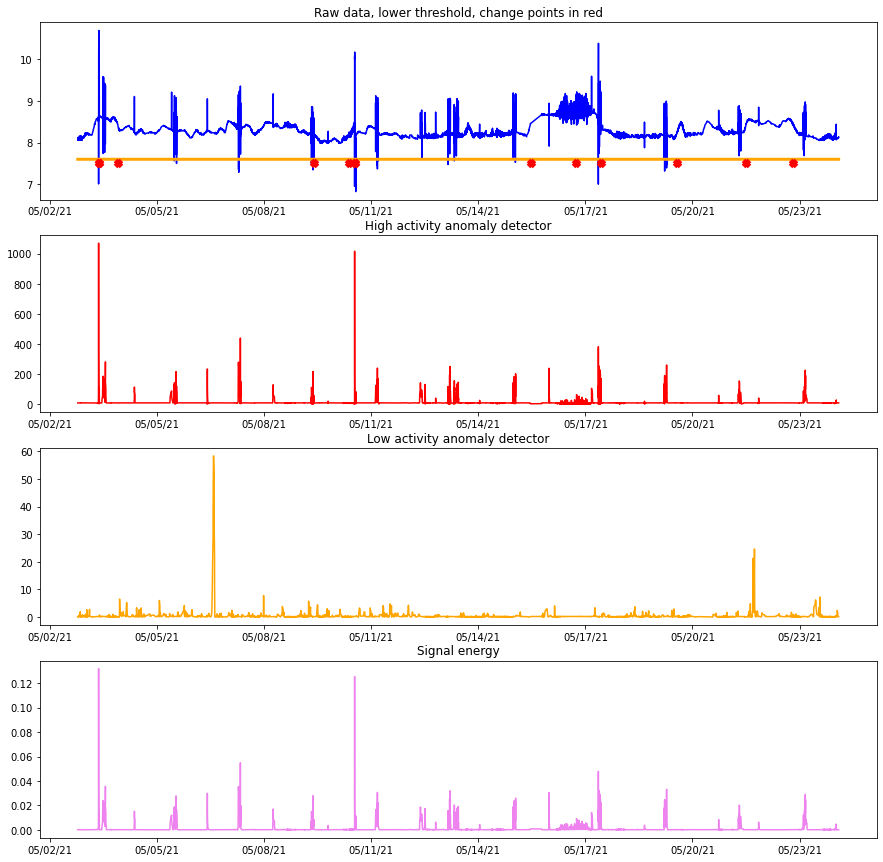

In [9]:
df = df1
rbi = rbi1
Range = slice(1000,32500)

arr = df[Temperature].values.copy()
arr[df[rob].values] = np.nan
df['Min'] = rbi.Min[next(iter(rbi.Min))]
df['Max'] = rbi.Max[next(iter(rbi.Max))]

arr2 = df[cpd].copy()
arr2[arr2 == 0] = np.nan

fig, ax = plt.subplots(4,1,figsize=(15,15))

ax[0].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[1].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[2].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[2].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[3].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[3].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
#Range = slice(1000,22500)

ax[0].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][Temperature], color='blue') #, figsize=(20,5))
ax[0].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range]['Min'], color='orange', lw=3)
ax[0].scatter(df[Range]['RCV_TIMESTAMP_UTC'], arr2[Range] + 6.5, color='red', marker='x', lw=5, zorder=10)

ax[0].set_title('Raw data, lower threshold, change points in red')
ax[1].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][spectral], color='red')

ax[1].set_title('High activity anomaly detector')
ax[2].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][spectralinv], color='orange')
ax[2].set_title('Low activity anomaly detector')
ax[3].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][signal], color='violet')
ax[3].set_title('Signal energy')
#ax[4].scatter(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][Temperature], color='blue', marker='.', linewidths=0.5)
#ax[4].set_title('Raw data and change points')


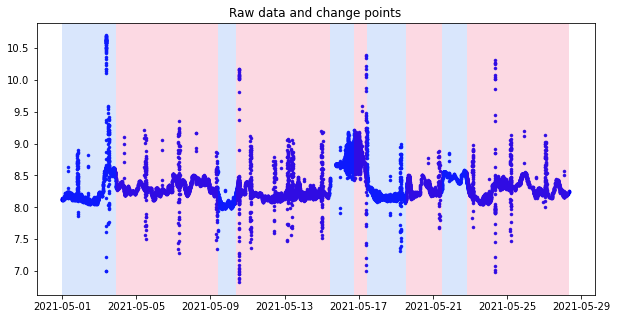

In [10]:
from itertools import cycle

sig_x = df1['RCV_TIMESTAMP_UTC'].values
sig_y = df1[Temperature].values

model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
#algo = rpt.Binseg(model="l2").fit(sig_y)
#chg_pts = algo.predict(n_bkps=4)

#algo = rpt.Pelt(model="l1", min_size=3, jump=5).fit(sig_y)
#chg_pts = algo.predict(pen=3)

algo = rpt.BottomUp(model="l2", jump=2).fit(sig_y)
chg_pts = algo.predict(n_bkps=15)

# show results
fig, ax = plt.subplots(1,1,figsize=(10,5))

#ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))

ax.scatter(sig_x, sig_y, color='blue', marker='.', linewidths=0.5)
ax.set_title('Raw data and change points')

color_cycle = cycle(["#4286f4", "#f44174"])

# color each (true) regime
bkps = [sig_x[0]] + [sig_x[i-1] for i in sorted(chg_pts)]
alpha = 0.2  # transparency of the colored background

for (start, end), col in zip(rpt.utils.pairwise(bkps), color_cycle):
    #ax.axvspan(max(0, start - 0.5), end - 0.5, facecolor=col, alpha=alpha)
    ax.axvspan(start, end, facecolor=col, alpha=alpha)


Text(0.5, 1.0, 'Bimodal distribution')

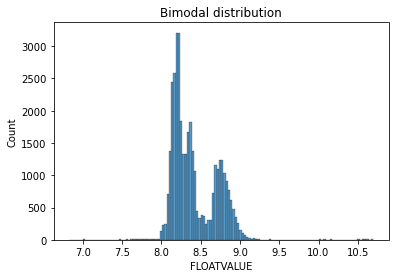

In [11]:
sns.histplot(data=df1[Temperature]).set_title('Bimodal distribution')

In [12]:
from sklearn.mixture import BayesianGaussianMixture
nr_comp = 2

BGM1 = BayesianGaussianMixture(n_components=nr_comp, verbose=1, n_init=5,
                              init_params='random', weight_concentration_prior_type='dirichlet_distribution',
                              covariance_type='full')
#BGM.mean_prior = [[2.3, 3.5, 0], [0,0,0]]
BGM1.fit(df1[Temperature].values.reshape(-1,1))
#BGM.fit(data_)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


BayesianGaussianMixture(init_params='random', n_components=2, n_init=5,
                        verbose=1,
                        weight_concentration_prior_type='dirichlet_distribution')

In [13]:
"weights", BGM1.weights_, "means", BGM1.means_, "precision", BGM1.precisions_

('weights',
 array([0.51403369, 0.48596631]),
 'means',
 array([[8.22015199],
        [8.61994603]]),
 'precision',
 array([[[128.08221385]],
 
        [[ 11.88662058]]]))

[[8.19672953]] [[8.24357444]]
[[8.36756143]] [[8.87233064]]


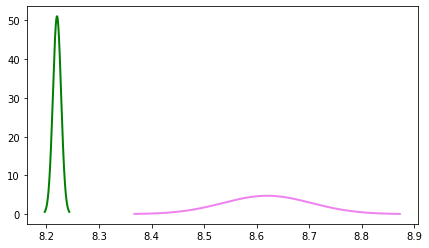

In [14]:
x = [None, None]
y = [None, None]
for i in [0,1]:
    #mu = scaler.inverse_transform(BGM.means_[i])
    mu = BGM1.means_[i]
    sigma = 1/BGM1.precisions_[i]
    print (mu - 3*sigma, mu + 3*sigma)
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x[i] = np.arange(mu - 3*sigma, mu + 3*sigma, 0.0001)

    #print (x)
    y[i] = sp.stats.norm.pdf(x[i], mu, sigma).reshape(-1,)
    #print (y)
    
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(x[0], y[0], color='green', lw=2)
ax.plot(x[1], y[1], color='violet', lw=2)

In [15]:
# deviceid f86857a7-2823-3105-8da7-f34637c96f0e
# tag path ca5/hvac/ac/ac3/disc air temp active
df2_raw = pd.read_csv('IOT_TAGDATA_TYPE_202106151221_ca5_hvac_ac_ac3_disc-air-temp-active.csv',
                     parse_dates=['RCV_TIMESTAMP_UTC'], infer_datetime_format=True)
df2_raw['RCV_TIMESTAMP_UTC'] = pd.to_datetime(df2_raw['RCV_TIMESTAMP_UTC'], 
                                            format='%Y-%m-%d-%H.%M.%S.%f')
df2_raw = df2_raw.sort_values('RCV_TIMESTAMP_UTC')
df2_i = df2_raw.set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])

In [16]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv, signal)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
spsi._entity_type = et
df2_i = spsi.execute(df=df2_i)

2021-06-23T12:10:19.988 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


In [17]:
rbi2 = RobustThreshold(Temperature, 0.99, rob)
#rbi2.delete_model = True
et = rbi2._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
rbi2._entity_type = et
df2_i = rbi2.execute(df=df2_i)

2021-06-23T12:10:20.169 INFO iotfunctions.anomaly.__init__ RobustThreshold from FLOATVALUE quantile threshold 0.99 exceeding boolean FLOATVALUE_rob
2021-06-23T12:10:20.170 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-06-23T12:10:20.184 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_ROBUSTTHRESHOLD.SupervisedLearningTransformer.FLOATVALUE_rob.f86857a7-2823-3105-8da7-f34637c96f0e of size 538499 bytes has been retrieved from filesystem
2021-06-23T12:10:20.185 INFO iotfunctions.anomaly.load_model load model <iotfunctions.anomaly.KDEMaxMin object at 0x7f930c0fbac0>


In [18]:
cpdi2 = ChangePointDetector(Temperature, cpd)
#rbi1.delete_model = True
et = cpdi2._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
cpdi2._entity_type = et
df2_i = cpdi1.execute(df=df2_i)

2021-06-23T12:10:20.196 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
0 [2656, 3456, 4040, 4952, 7424, 8206, 9108, 9592, 10400, 11536, 12436, 13286, 16032, 20242, 23536, 30516]


In [19]:
df2 = df2_i.reset_index()

Text(0.5, 1.0, 'Signal energy')

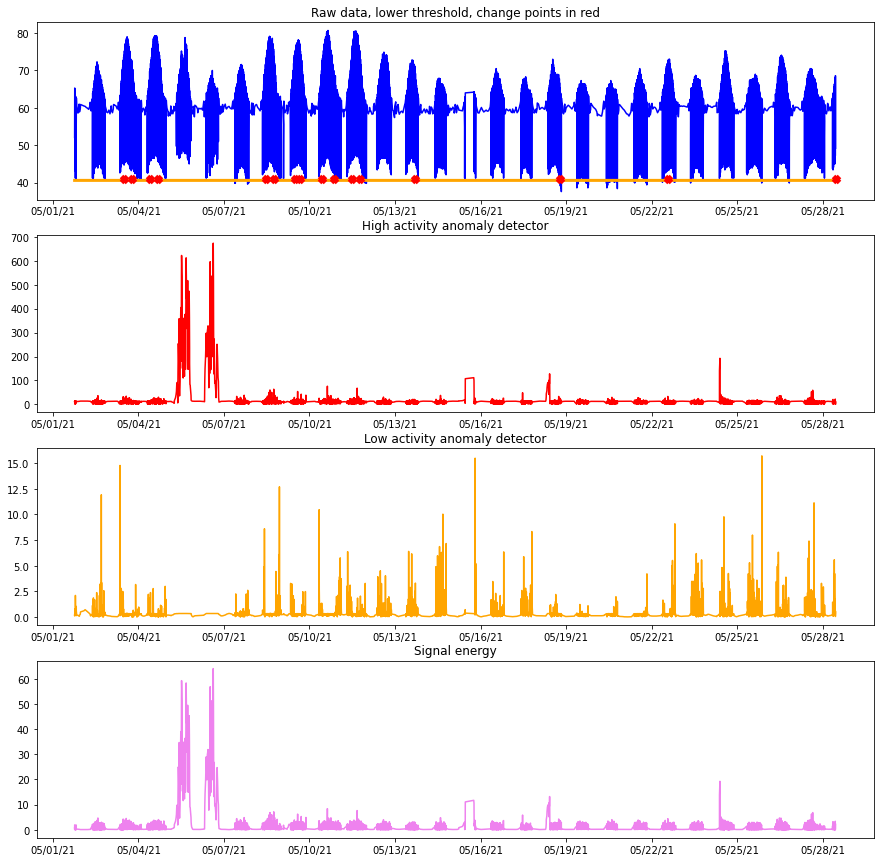

In [20]:
df = df2
rbi = rbi2
Range = slice(1000,32500)

arr = df[Temperature].values.copy()
arr[df[rob].values] = np.nan
df['Min'] = rbi.Min[next(iter(rbi.Min))]
df['Max'] = rbi.Max[next(iter(rbi.Max))]

arr2 = df[cpd].copy()
arr2[arr2 == 0] = np.nan

fig, ax = plt.subplots(4,1,figsize=(15,15))

ax[0].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[1].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[2].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[2].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[3].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[3].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))

ax[0].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][Temperature], color='blue') #, figsize=(20,5))
ax[0].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range]['Min'], color='orange', lw=3)
ax[0].scatter(df[Range]['RCV_TIMESTAMP_UTC'], arr2[Range] + 40, color='red', marker='x', lw=5, zorder=10)

ax[0].set_title('Raw data, lower threshold, change points in red')
ax[1].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][spectral], color='red')

ax[1].set_title('High activity anomaly detector')
ax[2].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][spectralinv], color='orange')
ax[2].set_title('Low activity anomaly detector')
ax[3].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][signal], color='violet')
ax[3].set_title('Signal energy')

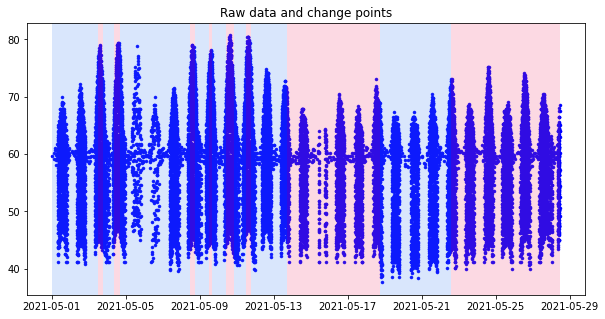

In [21]:
from itertools import cycle

sig_x = df2['RCV_TIMESTAMP_UTC'].values
sig_y = df2[Temperature].values

model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
#algo = rpt.Binseg(model="l2").fit(sig_y)
#chg_pts = algo.predict(n_bkps=4)

#algo = rpt.Pelt(model="l1", min_size=3, jump=5).fit(sig_y)
#chg_pts = algo.predict(pen=3)

algo = rpt.BottomUp(model="l2", jump=2).fit(sig_y)
chg_pts = algo.predict(n_bkps=15)

# show results
fig, ax = plt.subplots(1,1,figsize=(10,5))

#ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))

ax.scatter(sig_x, sig_y, color='blue', marker='.', linewidths=0.5)
ax.set_title('Raw data and change points')

color_cycle = cycle(["#4286f4", "#f44174"])

# color each (true) regime
bkps = [sig_x[0]] + [sig_x[i-1] for i in sorted(chg_pts)]
alpha = 0.2  # transparency of the colored background

for (start, end), col in zip(rpt.utils.pairwise(bkps), color_cycle):
    #ax.axvspan(max(0, start - 0.5), end - 0.5, facecolor=col, alpha=alpha)
    ax.axvspan(start, end, facecolor=col, alpha=alpha)


Text(0.5, 1.0, 'Multimodal distribution')

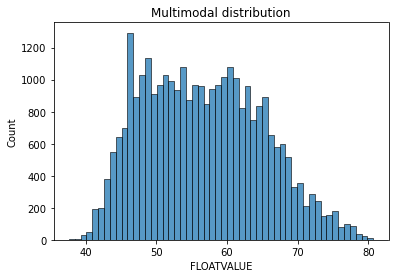

In [22]:
sns.histplot(data=df2[Temperature]).set_title('Multimodal distribution')

In [23]:
from sklearn.mixture import BayesianGaussianMixture
nr_comp = 2

BGM2 = BayesianGaussianMixture(n_components=nr_comp, verbose=1, n_init=5,
                              init_params='random', weight_concentration_prior_type='dirichlet_distribution',
                              covariance_type='full')
#BGM.mean_prior = [[2.3, 3.5, 0], [0,0,0]]
BGM2.fit(df2[Temperature].values.reshape(-1,1))
#BGM.fit(data_)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: False
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: False
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
Initialization converged: False
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True


BayesianGaussianMixture(init_params='random', n_components=2, n_init=5,
                        verbose=1,
                        weight_concentration_prior_type='dirichlet_distribution')

[[-75.06640614]] [[196.93095894]]
[[8.41989264]] [[88.69539612]]


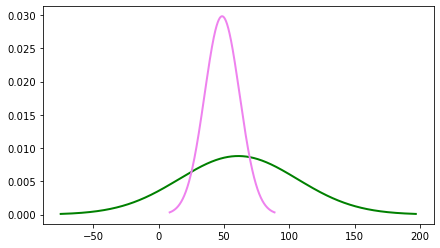

In [24]:
x = [None, None]
y = [None, None]
for i in [0,1]:
    #mu = scaler.inverse_transform(BGM.means_[i])
    mu = BGM2.means_[i]
    sigma = 1/BGM2.precisions_[i]
    print (mu - 3*sigma, mu + 3*sigma)
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x[i] = np.arange(mu - 3*sigma, mu + 3*sigma, 0.0001)

    #print (x)
    y[i] = sp.stats.norm.pdf(x[i], mu, sigma).reshape(-1,)
    #print (y)
    
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(x[0], y[0], color='green', lw=2)
ax.plot(x[1], y[1], color='violet', lw=2)
#ax.plot(x[2], y[2], color='blue', lw=2)

In [4]:
# deviceid 81bad898-7be1-37fb-ae0c-036d49cdcd1f
# tag path ca3e/hvac/scrubbers/shx7/at702/eu

df3_raw = pd.read_csv('IOT_TAGDATA_TYPE_202106141954_ca3e_hvac_scrubbers_shx7_at702_eu.csv',
                     parse_dates=['RCV_TIMESTAMP_UTC'], infer_datetime_format=True)
df3_raw['RCV_TIMESTAMP_UTC'] = pd.to_datetime(df3_raw['RCV_TIMESTAMP_UTC'], 
                                            format='%Y-%m-%d-%H.%M.%S.%f')
df3_raw = df3_raw.sort_values('RCV_TIMESTAMP_UTC')
df3_i = df3_raw.set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])

In [5]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv, signal)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
spsi._entity_type = et
df3_i = spsi.execute(df=df3_i)

2021-06-25T12:35:55.049 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-06-25T12:35:55.072 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-25T12:35:55.073 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


In [6]:
rbi3 = RobustThreshold(Temperature, 0.99, rob)
#rbi3.delete_model = True
et = rbi3._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
rbi3._entity_type = et
df3_i = rbi3.execute(df=df3_i)

2021-06-25T12:35:55.658 INFO iotfunctions.anomaly.__init__ RobustThreshold from FLOATVALUE quantile threshold 0.99 exceeding boolean FLOATVALUE_rob
2021-06-25T12:35:55.661 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-06-25T12:35:55.673 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_ROBUSTTHRESHOLD.SupervisedLearningTransformer.FLOATVALUE_rob.81bad898-7be1-37fb-ae0c-036d49cdcd1f of size 66647 bytes has been retrieved from filesystem
2021-06-25T12:35:55.674 INFO iotfunctions.anomaly.load_model load model <iotfunctions.anomaly.KDEMaxMin object at 0x7f45d9483c40>


In [7]:

#EngineLogging.configure_console_logging(logging.DEBUG)
cpdi3 = ChangePointDetector(Temperature, 12, cpd)
#rbi1.delete_model = True
et = cpdi3._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
cpdi3._entity_type = et
df3_i = cpdi3.execute(df=df3_i)

2021-06-25T12:35:56.276 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


In [14]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

ensi = EnsembleAnomalyScore(Temperature, 12, 
    'SpectralAnomalyScoreExt,KMeansAnomalyScore,GeneralizedAnomalyScore,MatrixProfileAnomalyScore,ChangePointDetector',
                            '100,1,1,1,3', 'Test')
#rbi1.delete_model = True
et = ensi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
ensi._entity_type = et
df3_i = ensi.execute(df=df3_i)

SpectralAnomalyScoreExt
KMeansAnomalyScore
GeneralizedAnomalyScore
MatrixProfileAnomalyScore
ChangePointDetector
2021-06-25T12:39:43.136 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-06-25T12:39:43.138 INFO mmfunctions.anomaly.execute Execute anomaly scorer SpectralAnomalyScoreExt with threshold 100
2021-06-25T12:39:43.172 INFO mmfunctions.anomaly.execute Executed anomaly scorer SpectralAnomalyScoreExt in 33 milliseconds
2021-06-25T12:39:43.173 INFO mmfunctions.anomaly.execute Execute anomaly scorer KMeansAnomalyScore with threshold 1
2021-06-25T12:39:43.184 INFO mmfunctions.anomaly.view_as_windows VIEW (3714,) 12 6
2021-06-25T12:39:43.184 INFO mmfunctions.anomaly.moving_window MOVE 6
2021-06-25T12:40:00.699 INFO mmfunctions.anomaly.execute Executed anomaly scorer KMeansAnomalyScore in 17525 milliseconds
2021-06-25T12:40:00.707 INFO mmfunctions.anomaly.execute Execut

In [80]:
df3e = df3_i.copy()

In [81]:
df3e = df3e.reset_index().set_index(['DEVICEID', 'RCV_TIMESTAMP_UTC','UPDATED_UTC'])

In [84]:
df3e.index.names[0:1] + df3e.index.names[2:]

FrozenList(['DEVICEID', 'UPDATED_UTC'])

In [74]:
df3e2 = df3e.reset_index(df3e.index.names[1:])

In [77]:
df3e2.index.names

FrozenList(['DEVICEID'])

In [17]:
#df3_i[['']]

In [18]:
df3 = df3_i.reset_index()

Text(0.5, 1.0, 'Ensemble Anomaly: Spectral (high, low), KMeans, MatrixProfile, ChangePoints')

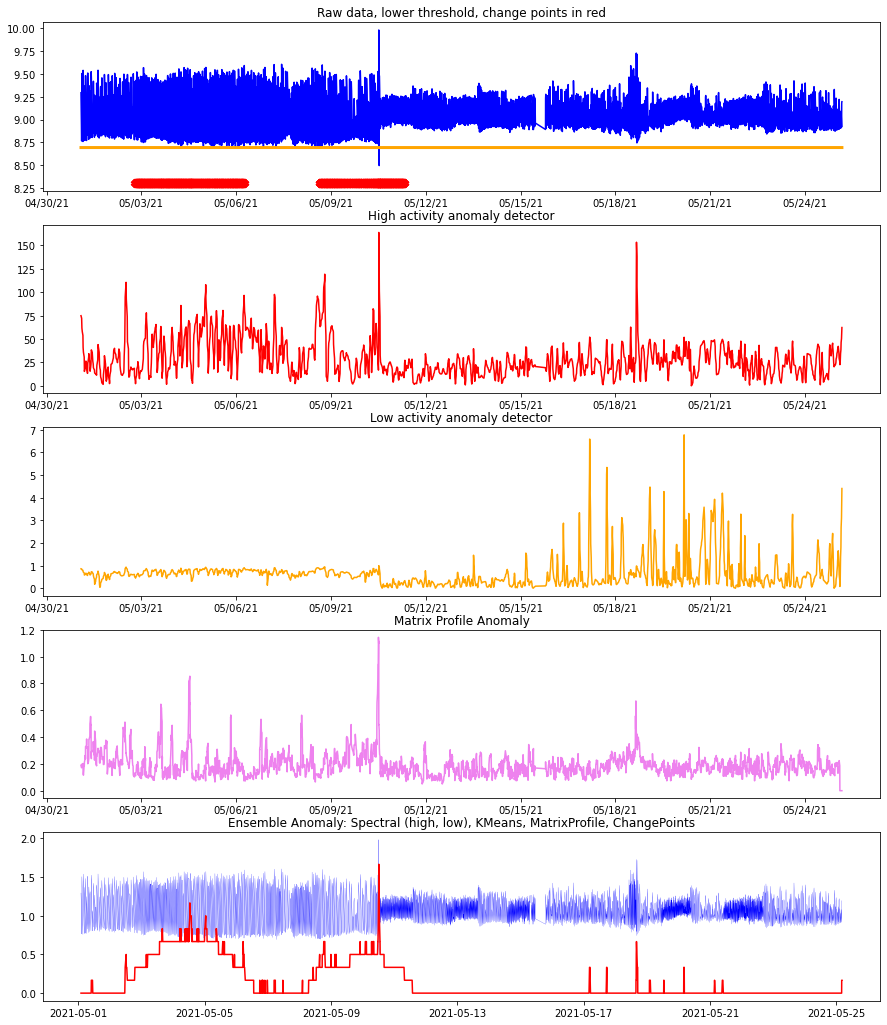

In [26]:
df = df3
rbi = rbi3
Range = slice(10,4500)
#Range = slice(1000,4500)

arr = df[Temperature].values.copy()
arr[df[rob].values] = np.nan
df['Min'] = rbi.Min[next(iter(rbi.Min))]
df['Max'] = rbi.Max[next(iter(rbi.Max))]

arr2 = df[cpd].copy()
arr2[arr2 < 3] = np.nan
arr2[arr2 >= 3] = 0

fig, ax = plt.subplots(5,1,figsize=(15,18))

ax[0].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[1].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[2].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[2].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[3].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[3].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[3].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[3].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))

ax[0].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][Temperature], color='blue') #, figsize=(20,5))
ax[0].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range]['Min'], color='orange', lw=3)
ax[0].scatter(df[Range]['RCV_TIMESTAMP_UTC'], arr2[Range] + 8.3, color='red', marker='x', lw=5, zorder=10)

ax[0].set_title('Raw data, lower threshold, change points in red')
ax[1].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][spectral], color='red')

ax[1].set_title('High activity anomaly detector')
ax[2].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][spectralinv], color='orange')
ax[2].set_title('Low activity anomaly detector')
ax[3].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range]['Test_ensemble_MatrixProfileAnomalyScore'], color='violet')
ax[3].set_title('Matrix Profile Anomaly')
ax[4].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range][Temperature]-8, color='blue', lw=0.2) 
ax[4].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range]['Test'], color='red', zorder=5)
ax[4].set_title('Ensemble Anomaly: Spectral (high, low), KMeans, MatrixProfile, ChangePoints')


(10000,)


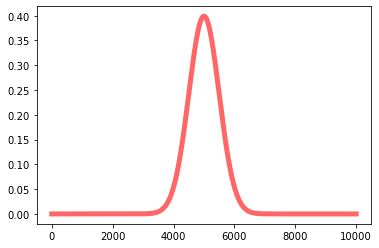

In [12]:
from scipy.stats import norm
a = 1 
b = 2
#x = np.linspace(norm.ppf(1/12), norm.ppf(11/12), 12)
x = np.arange(0, 10000, 1)
print(x.shape)

y = sp.stats.norm(5000, 500)

#print(x)
fig, ax = plt.subplots(1, 1)
ax.plot(x, y.pdf(x) * 500,'r-', lw=5, alpha=0.6, label='truncnorm pdf')

In [13]:
'''
from itertools import combinations, permutations
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray

def kendalltau_dist(rank_a, rank_b):
    tau = 0
    n_candidates = len(rank_a)
    for i, j in combinations(range(n_candidates), 2):
        tau += (np.sign(rank_a[i] - rank_a[j]) ==
                -np.sign(rank_b[i] - rank_b[j]))
    return tau

def _build_graph(ranks):
    n_voters, n_candidates = ranks.shape
    edge_weights = np.zeros((n_candidates, n_candidates))
    for i, j in combinations(range(n_candidates), 2):
        preference = ranks[:, i] - ranks[:, j]
        h_ij = np.sum(preference < 0)  # prefers i to j
        h_ji = np.sum(preference > 0)  # prefers j to i
        if h_ij > h_ji:
            edge_weights[i, j] = h_ij - h_ji
        elif h_ij < h_ji:
            edge_weights[j, i] = h_ji - h_ij
    return edge_weights


def rankaggr_lp(ranks):
    """Kemeny-Young optimal rank aggregation"""

    n_voters, n_candidates = ranks.shape
    
    s = CyClpSimplex()
    
    # to state pairwise and triangle constraints like x(ij) + x(ji) = 1
    x = s.addVariable('x', n_candidates ** 2)
    
    
    # minimize c.T * x
    edge_weights = _build_graph(ranks)
    c = 1 * edge_weights.ravel()  
    
    idx = lambda i, j: n_candidates * i + j
    
    print (n_voters, n_candidates)
    
    # constraints to ensure elements >= 0
    uni_constraints = np.zeros((n_candidates ** 2, n_candidates ** 2))
    for i in range(0, n_candidates ** 2):
        uni_constraints[i,i] = 1
        
    UniConstraints = np.asmatrix(uni_constraints)
    s += UniConstraints * x >= 0
    
    # constraints for every pair - shape (10, 25)
    pairwise_constraints = np.zeros((int((n_candidates * (n_candidates - 1)) / 2),
                                      n_candidates ** 2))
        
    for row, (i, j) in zip(pairwise_constraints,
                           combinations(range(n_candidates), 2)):
        row[[idx(i, j), idx(j, i)]] = 1
    
    
    PairwiseConstraints = np.asmatrix(pairwise_constraints)

    s += PairwiseConstraints * x == 1

    # and for every cycle of length 3 - shape (60, 25)
    triangle_constraints = np.zeros(((n_candidates * (n_candidates - 1) *
                                     (n_candidates - 2)), n_candidates ** 2))
    
    for row, (i, j, k) in zip(triangle_constraints,
                              permutations(range(n_candidates), 3)):
        row[[idx(i, j), idx(j, k), idx(k, i)]] = 1

    TriangleConstraints = np.asmatrix(triangle_constraints)
  
    s += TriangleConstraints * x == 1
    
    # print (s.constraints)
    
    ObjectiveMatrix = np.asmatrix(c)
    print (ObjectiveMatrix.shape)
    
    # print (ObjectiveMatrix)
    s.objective = ObjectiveMatrix * x
    
    # Solve using primal Simplex
    s.primal()
    X = s.primalVariableSolution['x']
        
    # cs = CyClpSimplex()
    # obj, x, duals = CyClpSimplex(c, constraints, constraint_rhs, constraint_signs,
    #                        xint=range(1, 1 + n_candidates ** 2))

    X = np.array(X).reshape((n_candidates, n_candidates))
    print (X)
    aggr_rank = X.sum(axis=1)

    return aggr_rank
'''

'\nfrom itertools import combinations, permutations\nfrom cylp.cy import CyClpSimplex\nfrom cylp.py.modeling.CyLPModel import CyLPArray\n\ndef kendalltau_dist(rank_a, rank_b):\n    tau = 0\n    n_candidates = len(rank_a)\n    for i, j in combinations(range(n_candidates), 2):\n        tau += (np.sign(rank_a[i] - rank_a[j]) ==\n                -np.sign(rank_b[i] - rank_b[j]))\n    return tau\n\ndef _build_graph(ranks):\n    n_voters, n_candidates = ranks.shape\n    edge_weights = np.zeros((n_candidates, n_candidates))\n    for i, j in combinations(range(n_candidates), 2):\n        preference = ranks[:, i] - ranks[:, j]\n        h_ij = np.sum(preference < 0)  # prefers i to j\n        h_ji = np.sum(preference > 0)  # prefers j to i\n        if h_ij > h_ji:\n            edge_weights[i, j] = h_ij - h_ji\n        elif h_ij < h_ji:\n            edge_weights[j, i] = h_ji - h_ij\n    return edge_weights\n\n\ndef rankaggr_lp(ranks):\n    """Kemeny-Young optimal rank aggregation"""\n\n    n_voter

In [14]:
x = np.array([0, 8, 7, 4, 3, 5, 3, 1,2,3,2,3,4, 4,2,5])
bins = [0,2,4,7]

bins = np.searchsorted(bins, x, side='left')
bins

array([0, 4, 3, 2, 2, 3, 2, 1, 1, 2, 1, 2, 2, 2, 1, 3])

In [122]:
np.vstack([bins,bins]).T

array([[0, 0],
       [4, 4],
       [3, 3],
       [2, 2],
       [2, 2],
       [3, 3],
       [2, 2],
       [1, 1],
       [1, 1],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [2, 2],
       [1, 1],
       [3, 3]])

In [34]:
# build rank matrix

arr1 = df3[Range][spectral].values
arr_ind1 = np.argsort(arr1)
arr2 = df3[Range][cpd].values
arr_ind2 = np.argsort(arr2)
arr3 = df3[Range][spectralinv].values
arr_ind3 = np.argsort(arr3)

rank_mat = np.vstack([arr_ind1, arr_ind2, arr_ind3])

rank_mat.shape



(3, 2714)

In [39]:
def get_payoff_matrix_plurality_game(majority_graph_matrix):
    '''return the payoff matrix of the plurality game plurality_game[i,j] = n_ij-n_ji'''

    plurality_game = np.zeros(majority_graph_matrix.shape, int)
    for i, j in combinations(range(0,majority_graph_matrix.shape[0]), 2):
        weight = majority_graph_matrix[i, j] - majority_graph_matrix[j, i]
        plurality_game[i,j] = weight
        plurality_game[j,i] = -weight

    #logger.debug("Compute the payoff matrix of the plurality game:  \r\n" + str(plurality_game))
    return plurality_game

In [48]:
payoff_matrix = get_payoff_matrix_plurality_game(rank_mat).T

In [46]:
payoff_matrix.T

array([[    0, -1978,  -108],
       [ 1978,     0,   374],
       [  108,  -374,     0],
       ...,
       [    0,     0,     0],
       [    0,     0,     0],
       [    0,     0,     0]])

In [132]:
aggr = rankaggr_lp(rank_mat)

3 50
(1, 2500)
[[   0.          -74.81465517  -86.06896552 ... -119.47844828
   -84.77586207 -106.23275862]
 [  74.81465517    0.          -11.25431034 ...  -35.35344828
    -0.65086207  -22.10775862]
 [  87.06896552    2.94396552    0.         ...  -32.35775862
     3.2112069   -19.1637931 ]
 ...
 [ 110.11637931   35.19827586  -24.21982759 ...    0.
    35.88793103   13.19396552]
 [  74.54741379    0.           -2.84913793 ...  -15.36206897
     0.          -22.375     ]
 [ 116.18103448   22.32327586   20.1637931  ...  -12.92672414
    23.01293103    0.        ]]


In [134]:
score = np.sum(kendalltau_dist(aggr, rank) for rank in rank_mat)
print("A Kemeny-Young aggregation with score {} is: {}".format(
    score,
    ", ".join(str(i) for i in np.argsort(aggr))))

A Kemeny-Young aggregation with score 1840 is: 45, 28, 8, 12, 7, 15, 11, 0, 39, 38, 27, 4, 3, 25, 44, 29, 33, 21, 43, 9, 23, 18, 16, 26, 42, 30, 32, 35, 1, 48, 14, 46, 2, 34, 40, 37, 31, 10, 24, 13, 41, 20, 22, 36, 5, 49, 47, 19, 6, 17


<ipython-input-134-0ada380e088a>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score = np.sum(kendalltau_dist(aggr, rank) for rank in rank_mat)


<AxesSubplot:>

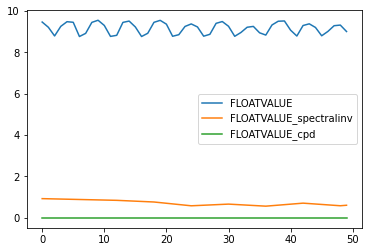

In [111]:
df3[Range][['FLOATVALUE', spectralinv, cpd]].plot()

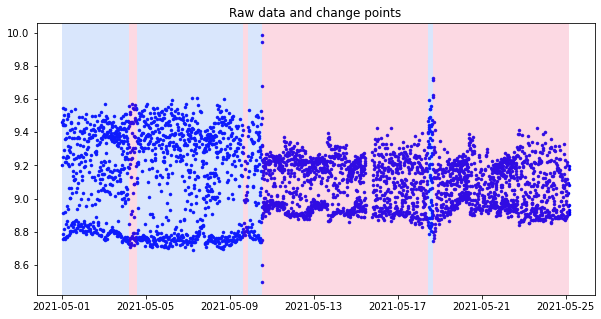

In [82]:
from itertools import cycle

sig_x = df3['RCV_TIMESTAMP_UTC'].values
sig_y = df3[Temperature].values

model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
#algo = rpt.Binseg(model="l2").fit(sig_y)
#chg_pts = algo.predict(n_bkps=4)

#algo = rpt.Pelt(model="l1", min_size=3, jump=5).fit(sig_y)
#chg_pts = algo.predict(pen=3)

algo = rpt.BottomUp(model="l2", jump=2).fit(sig_y)
chg_pts = algo.predict(n_bkps=15)

# show results
fig, ax = plt.subplots(1,1,figsize=(10,5))

#ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))

ax.scatter(sig_x, sig_y, color='blue', marker='.', linewidths=0.5)
ax.set_title('Raw data and change points')

color_cycle = cycle(["#4286f4", "#f44174"])

# color each (true) regime
bkps = [sig_x[0]] + [sig_x[i-1] for i in sorted(chg_pts)]
alpha = 0.2  # transparency of the colored background

for (start, end), col in zip(rpt.utils.pairwise(bkps), color_cycle):
    #ax.axvspan(max(0, start - 0.5), end - 0.5, facecolor=col, alpha=alpha)
    ax.axvspan(start, end, facecolor=col, alpha=alpha)

#rpt.display(df3[Temperature], chg_pts)

In [87]:
# 8eefd532-57be-3742-ae59-5fa11597c2fd
# ca3/awn/ph_control/scex1/ait2310/eu
df4_raw = pd.read_csv('IOT_TAGDATA_TYPE_202106161003_ca3_awn_ph_control_scex1_ait2310_eu.csv',
                     parse_dates=['RCV_TIMESTAMP_UTC'], infer_datetime_format=True)
df4_raw['RCV_TIMESTAMP_UTC'] = pd.to_datetime(df4_raw['RCV_TIMESTAMP_UTC'], 
                                            format='%Y-%m-%d-%H.%M.%S.%f')
df4_raw = df4_raw.sort_values('RCV_TIMESTAMP_UTC')
df4_i = df4_raw.set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])

In [88]:
EngineLogging.configure_console_logging(logging.INFO)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = NoDataAnomalyScoreExt(Temperature, 'gap', 'nodata')
et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
spsi._entity_type = et
df4_i = spsi.execute(df=df4_i)

2021-06-17T11:49:11.352 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


In [89]:
df4 = df4_i.reset_index()
df4.head(1)

,DEVICEID,RCV_TIMESTAMP_UTC,TAGID,INTVALUE,FLOATVALUE,STRINGVALUE,DATEVALUE,EVT_NAME,DEVICETYPE,LOGICALINTERFACE_ID,EVENTTYPE,FORMAT,UPDATED_UTC,gap,nodata
0,8eefd532-57be-3742-ae59-5fa11597c2fd,2021-05-01 00:00:13.552,672937,0,9.022484,NaN,NaN,eu,TagData_Type,NaN,device,JSON,2021-05-01-00.00.13.552000,0.049103,20.0


Text(0.5, 1.0, 'No Data anomaly score')

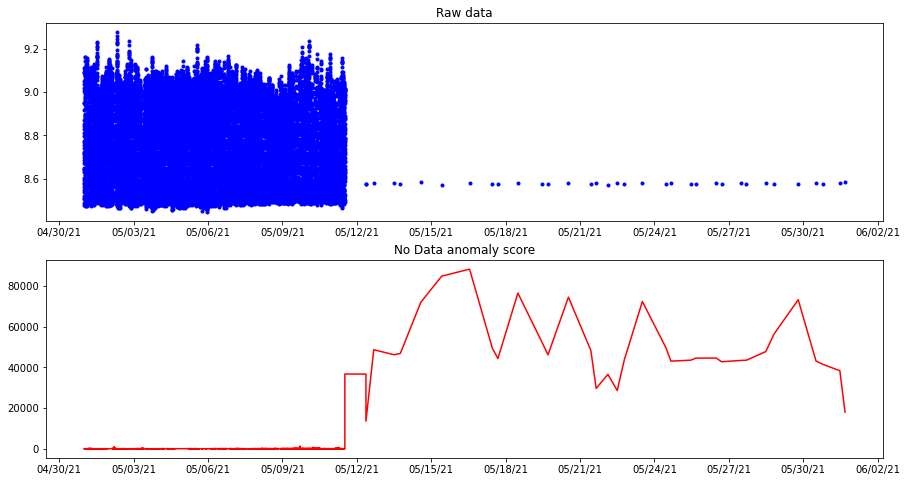

In [90]:
df4 = df4_i.reset_index()
df4.head(1)

fig, ax = plt.subplots(2,1,figsize=(15,8))

ax[0].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[1].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
#Range = slice(12000,21700)
Range = slice(10,21700)

#plt.figure(figsize=(20,7))

ax[0].scatter(df4[Range]['RCV_TIMESTAMP_UTC'], df4[Range][Temperature], color='blue', marker='.', linewidths=1)
ax[0].set_title('Raw data')
#ax[1].plot(df4[Range]['RCV_TIMESTAMP_UTC'], df4[Range]['gap'], color='darkgreen')
#ax[1].set_title('Gap metric')
ax[1].plot(df4[Range]['RCV_TIMESTAMP_UTC'], df4[Range]['nodata'], color='red')
ax[1].set_title('No Data anomaly score')

In [ ]:
# ca3/awn/ph_control/scex1/ait2311/eu
# 1e00b845-8459-3ab3-92f0-c1aadac16241
df5_raw = pd.read_csv('IOT_TAGDATA_TYPE_202106161003_ca3_awn_ph_control_scex1_ait2310_eu.csv',
                     parse_dates=['RCV_TIMESTAMP_UTC'], infer_datetime_format=True)
df5_raw['RCV_TIMESTAMP_UTC'] = pd.to_datetime(df5_raw['RCV_TIMESTAMP_UTC'], 
                                            format='%Y-%m-%d-%H.%M.%S.%f')
df5_raw = df5_raw.sort_values('RCV_TIMESTAMP_UTC')
df5_i = df5_raw.set_index(['DEVICEID','RCV_TIMESTAMP_UTC'])

In [80]:
def prepData(fileName, valueName):
    # Run on the good pump first 
    # Get stuff in
    df_i = pd.read_csv(fileName, index_col=False, parse_dates=['t_stamp'])
    #t_stamp,CA1/CDA/AC_Comp1/InterCoolTemp

    entity_name = [x for x in df_i.columns if not x.startswith('t_stamp')][0]
    entity_name_ = entity_name.replace('/','_')

    df_i['entity']=entity_name_  # NO SLASHES IN FILESYSTEM !
    df_i.rename(columns={'t_stamp':'timestamp', entity_name:valueName}, inplace=True)

    # and sort it by timestamp
    df_i = df_i.sort_values(by='timestamp')
    df_i = df_i.set_index(['entity','timestamp']).dropna()

    return df_i

def runSpectral(df_i):
    jobsettings = { 'db': db, 
                   '_db_schema': 'public', 'save_trace_to_file' : True}

    Temperature = df_i.columns[0]
    spectral = Temperature + '_spectral'
    spectralinv = Temperature + '_spectralinv'
    signal = Temperature + '_signal'
    
    spsi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv, signal)
    et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
    spsi._entity_type = et
    df_i = spsi.execute(df=df_i)
    return df_i

def runCPD(df_i):
    jobsettings = { 'db': db, 
                   '_db_schema': 'public', 'save_trace_to_file' : True}
    
    Temperature = df_i.columns[0]
    cpd = Temperature + '_cpd'
    cpdi = ChangePointDetector(Temperature, cpd)
    

    et = cpdi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
    cpdi._entity_type = et
    df_i = cpdi1.execute(df=df_i)

def computeL2Deriv(df_i, winsize, valueName):
    df_m = df_i.reset_index().set_index('timestamp')

    # partial L2-norm of 1st derivative
    Temperature = df_i.columns[0]
    
    temperature = df_m[Temperature].values
    slices_ = skiutil.view_as_windows(temperature, window_shape=(winsize,), step=1)

    Dslice_list = []
    for slice in slices_:
        Dslice_list.append(sp.linalg.norm(np.diff(slice)))
    DSlice = np.asarray(Dslice_list)

    #stretch it
    time_series_temperature = np.linspace(winsize // 2, temperature.size - winsize // 2 - 1, DSlice.size)

    temp_dl2_inter = sp.interpolate.interp1d(time_series_temperature, DSlice,
                                              kind='linear', fill_value='extrapolate')
    df_m['Fluctuation'] = temp_dl2_inter(np.arange(0, temperature.size))
    return df_m
    
def plotData(df_i, label, title, scale=[1,100,1]):
    df_m = df_i.reset_index().set_index('timestamp')
    plots = 1

    Temperature = df_i.columns[0]
    
    spectral = Temperature + '_spectral'
    spectralinv = Temperature + '_spectralinv'
    signal = Temperature + '_signal'
    
    fig, ax = plt.subplots(plots, 1, figsize=(15,10), squeeze=False)
    cnt = 0
    if scale[0] > 0:
        ax[cnt,0].plot(df_m.index, df_m[Temperature]/scale[0],linewidth=1,color='blue',label=label)
    if scale[1] > 0:
        ax[cnt,0].plot(df_m.index, df_m[spectral]/scale[1], linewidth=1, color='orange', label='Anomalous Activity')
    if scale[2] > 0:
        ax[cnt,0].plot(df_m.index, df_m[spectralinv]/scale[2], linewidth=1, color='red', label='Low Activity')
    ax[cnt,0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[cnt,0].set_ylabel(title,fontsize=12,weight="bold")
    

In [82]:
df_input = prepData('~/Bldg3E HVAC Chilled Water Supply Chart.csv', 'temp')
df_input = runSpectral(df_input)
df_input = runCPD(df_input)

2021-06-21T18:25:39.781 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


TypeError: __init__() missing 2 required positional arguments: 'chg_pts_sig' and 'chg_pts_inv'

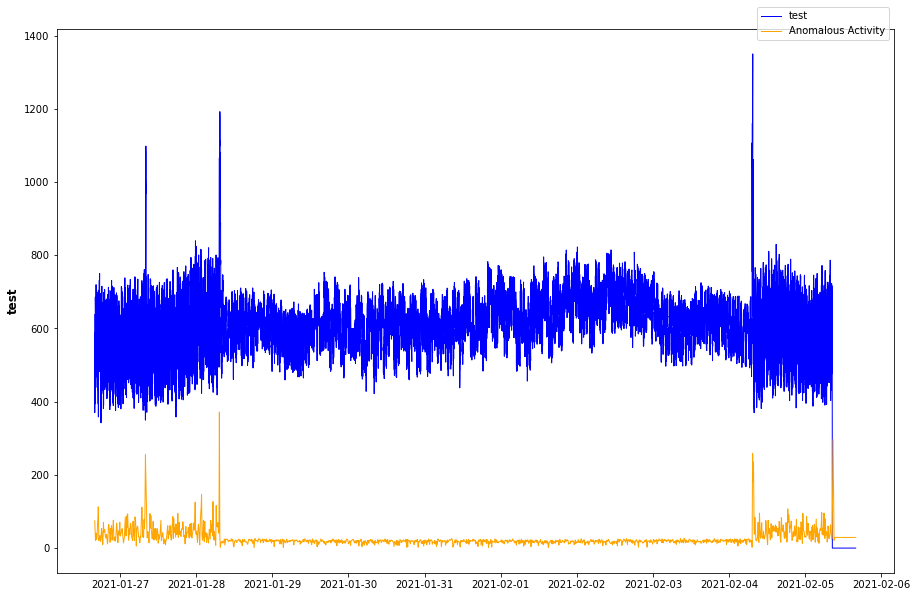

In [79]:
plotData(df_input, 'test', 'test', scale=[1,1,0])

In [6]:
df_input2 = prepData('~/Bldg3E HVAC Chilled Water Supply BypassFlow.csv', 'temp')
df_input2 = runSpectral(df_input2)

2021-04-20T14:39:40.358 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


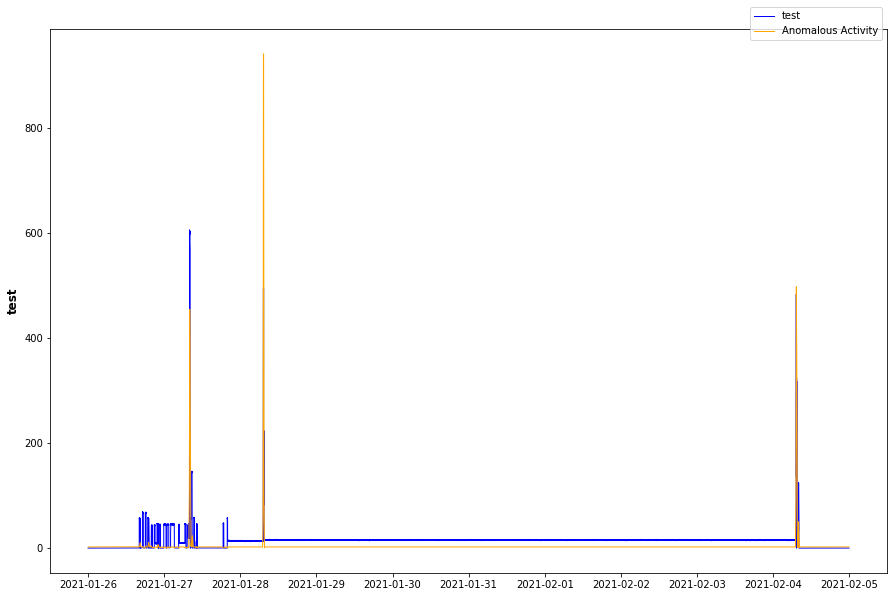

In [7]:
plotData(df_input2, 'test', 'test', scale=[1,1,0])

In [8]:
df_merge = pd.merge(df_input.reset_index(), df_input2.reset_index(),on='timestamp')
df_merge['entity'] = 'Chiller'
df_merge = df_merge.set_index(['entity','timestamp'])

In [9]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = KDEAnomalyScore(0.000001, ['temp_x'], ['temp_y'], ['tt_pred'])
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_merge = spsi.execute(df=df_merge)

EngineLogging.configure_console_logging(logging.INFO)
df_merge.describe()


2021-04-20T14:39:42.341 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-04-20T14:39:42.342 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2021-04-20T14:39:42.343 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-04-20T14:39:42.344 DEBUG iotfunctions.util.__init__ Starting trace
2021-04-20T14:39:42.344 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_KDEAnomalyScore_20210420123942
2021-04-20T14:39:42.344 DEBUG iotfunctions.util.__init__ auto_save None
2021-04-20T14:39:42.345 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-04-20T14:39:42.346 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-04-20T14:39:42.346 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_KDEANOMALYSCORE
Fu

,temp_x,tempspectral_x,tempspectralinv_x,temp_y,tempspectral_y,tempspectralinv_y,tt_pred
count,17256.000000,17256.000000,1.725600e+04,17256.000000,17256.000000,17256.000000,1.725600e+04
mean,615.619540,24.414491,1.193008e-01,16.202114,4.316086,0.478548,2.561109e-04
std,80.981863,20.068546,2.775638e-17,22.061159,31.439116,0.655296,1.351190e-04
min,342.056061,1.869826,1.193008e-01,0.000000,0.051955,0.315411,1.187383e-07
25%,562.868942,16.902352,1.193008e-01,14.778372,2.194742,0.315411,1.496194e-04
50%,617.634705,19.659898,1.193008e-01,15.353783,2.197149,0.315411,2.993349e-04
75%,668.396194,22.702487,1.193008e-01,15.980468,2.199182,0.315411,3.778426e-04
max,1350.042236,316.826648,1.193008e-01,605.981628,940.988924,3.170466,4.045989e-04


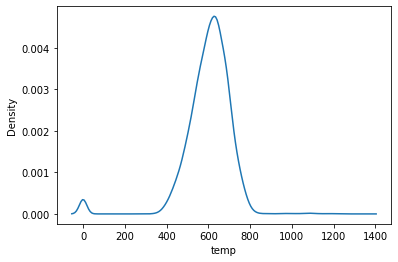

In [10]:
sns.kdeplot(data=df_input['temp'])


In [47]:
#https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-anomaly-detection-outliers-detection
from sklearn.neighbors import KernelDensity
X = df_input['temp'].values.reshape(-1,1)
kde = KernelDensity(kernel='gaussian')
kde.fit(X)
kde_X = kde.score_samples(X)

In [48]:
kde_X.shape

(9845,)

In [13]:
from scipy.stats.mstats import mquantiles

alpha_set = 0.995
tau_kde = mquantiles(kde_X, 1. - alpha_set)

tau_kde

array([-9.19593259])

In [14]:
outliers = np.argwhere(kde_X < tau_kde)
outliers = outliers.flatten()
X_outliers = X[outliers]

normal_samples = np.argwhere(kde_X >= tau_kde)
normal_samples = normal_samples.flatten()
X_valid = X[normal_samples]

print("Original Samples : ",X.shape[0])
print("Number of Outliers : ", len(outliers))
print("Number of Normal Samples : ", len(normal_samples))

Original Samples :  9845
Number of Outliers :  49
Number of Normal Samples :  9796


In [15]:
mx_ = np.where(kde_X < tau_kde, kde_X, -10000).max()
mx = X[np.argwhere(kde_X == mx_).flatten()[0]][0]
mx

804.66357421875

In [31]:
X_outliers[X_outliers > X_valid.max()].min()

816.122924804687

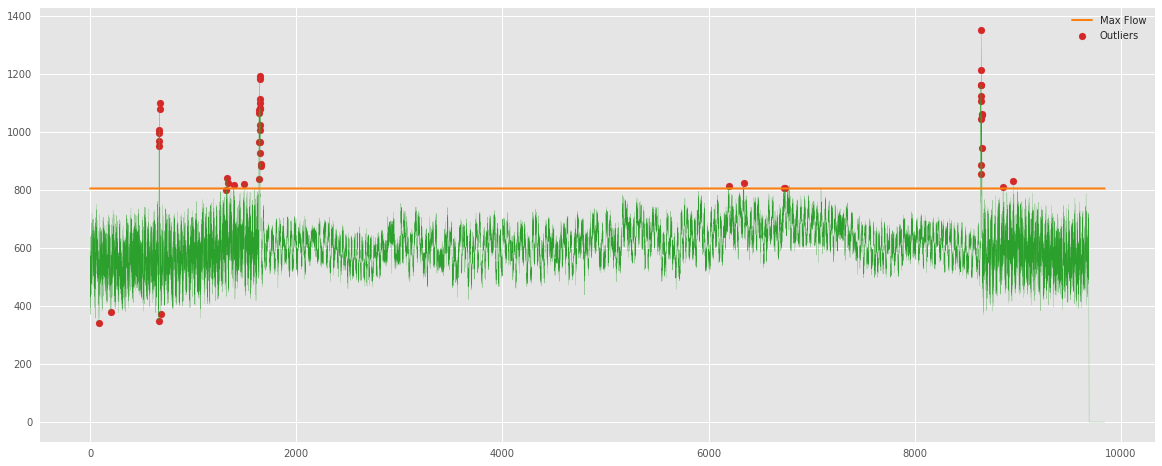

In [16]:
with plt.style.context(("seaborn", "ggplot")):
    plt.figure(figsize=(20,8))
    plt.plot(np.arange(0, X.shape[0], 1), X, c="tab:green", lw=0.2)
    plt.plot(np.arange(0,X.shape[0],1), np.ones(X.shape[0]) * mx, c="tab:orange", lw=2, label='Max Flow')
    #plt.plot(normal_samples, X_valid, c="tab:green", lw=0.2, label="Valid Samples")
    plt.scatter(outliers, X_outliers, c="tab:red", lw=0.2, label="Outliers")
    plt.legend(loc="best")
    

#plot_outliers_with_valid_samples(X_valid, X_outliers)

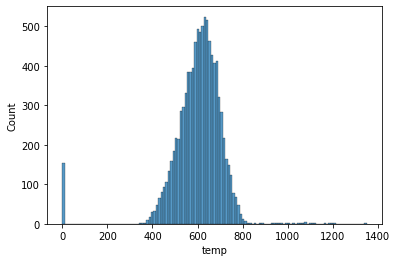

In [17]:
sns.histplot(data=df_input['temp'])

In [22]:
NO_DAY_OF_WEEK = True
#df_input.index.get_level_values(1)
df_input.index.get_level_values(1).hour

Int64Index([15, 15, 16, 16, 16, 16, 16, 16, 16, 16,
            ...
            15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
           dtype='int64', name='timestamp', length=9845)

In [22]:
%%time
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = GBMForecaster(['temp'], ['temp'], ['temp_pred'], [1,2,3,4,5,6])

et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi._entity_type = et
df_input = spsi.execute(df=df_input)

EngineLogging.configure_console_logging(logging.INFO)
df_input.describe()

2021-02-09T16:07:24.522 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
lags [1, 2, 3, 4, 5, 6]  lagged_features ['temp'] Train mode: True
2021-02-09T16:07:24.524 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-02-09T16:07:24.526 DEBUG iotfunctions.util.__init__ Starting trace
2021-02-09T16:07:24.529 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMForecaster_20210209150724
2021-02-09T16:07:24.532 DEBUG iotfunctions.util.__init__ auto_save None
2021-02-09T16:07:24.533 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-02-09T16:07:24.536 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-02-09T16:07:24.538 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMFORECASTER
Functions:
Granul

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and max_depth = 15
[LightGBM] [Debug] T

2021-02-09T16:07:27.401 DEBUG iotfunctions.base._execute Trained model: {
 "name": "model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.temp.CA3E_HVAC_CHW_FIT402_EU",
 "target": "temp",
 "features": [
  "temp_1",
  "temp_2",
  "temp_3",
  "temp_4",
  "temp_5",
  "temp_6"
 ],
 "estimator_name": "light_gradient_boosted_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 0.9787561807753178,
 "eval_metric_test": 0.7088045895290955,
 "trained_date": "2021-02-09T15:07:27.376369",
 "expiry_date": null,
 "col_name": "temp_pred",
 "col_name_stddev": null
}
2021-02-09T16:07:27.443 DEBUG iotfunctions.base.evaluate_and_write_model  wrote new model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.temp.CA3E_HVAC_CHW_FIT402_EU 
2021-02-09T16:07:27.444 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_GBMFORECASTER.GBMForecaster.temp.CA3E_HVAC_CHW_FIT402_EU
2021-02-09T16:07:27.444 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMFORECAS

,temp,tempspectral,tempspectralinv,_DayOfWeekCos_,_DayOfWeekSin_,_DayOfYearCos_,_DayOfYearSin_,temp_pred,diff
count,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000
mean,601.596497,26.732297,0.241580,0.887588,0.387615,0.996342,0.085090,601.366324,67.980119
std,113.155252,21.418921,0.994371,0.107075,0.224687,0.000669,0.007821,107.430805,57.850712
min,0.000000,1.869826,0.119301,0.654600,0.000000,0.995140,0.071173,-3.712408,0.040000
25%,552.898987,17.282529,0.119301,0.841129,0.281843,0.995665,0.079368,561.216919,28.729974
50%,613.842010,20.324431,0.119301,0.909560,0.415572,0.996395,0.084829,612.980798,51.953062
75%,666.853882,26.066623,0.119301,0.959461,0.540834,0.996845,0.093016,658.788874,81.785538
max,1350.042236,316.826648,8.382176,1.000000,0.755975,0.997464,0.098470,1230.492696,544.813645


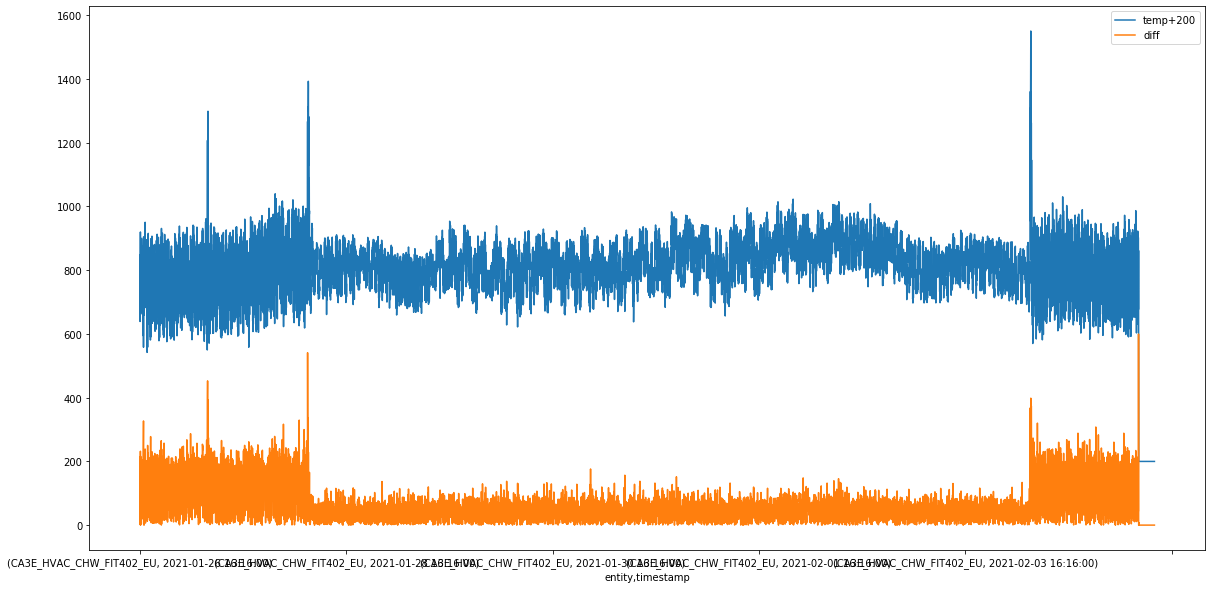

In [26]:
df_input2 = df_input[['temp','temp_pred']].copy()
df_input['diff'] = (df_input2['temp'] - df_input['temp_pred']).abs()
df_input['temp+200'] = df_input['temp'] + 200
df_input[['temp+200','diff']].plot(figsize=(20,10))

## Hic sunt leones

### Browse at your peril

Neither MCMC nor plain Bayesian Gaussian Mixture gave valuable results and I resorted to plain KDE as shown above. 

### Decompose into a mix of Gaussians

In [74]:
# https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html
import pymc3 as pm
import theano.tensor as tt

from pymc3 import (NUTS, DensityDist, Dirichlet, Metropolis, MvNormal, Normal, Slice, find_MAP, sample)
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )




In [181]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_ = scaler.fit_transform(df_input['temp'].values.reshape(-1,1))
data = np.hstack([data, data])
data.shape

(9832, 4)

In [149]:
# define model
ncomp = 2
dim = 2

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value) for i, mu in enumerate(mus)]
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :data.shape[0]], axis=0))

    return logp_




with pm.Model() as model:
    mus = [
        MvNormal("mu_%d" % i, mu=pm.floatX(np.zeros(dim)), tau=pm.floatX(0.1 * np.eye(dim)), shape=(dim,))
        for i in range(2)
    ]
    pi = Dirichlet("pi", a=pm.floatX(0.1 * np.ones(ncomp)), shape=(ncomp,))
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(dim)), observed=data)

In [150]:
%%time
'''
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)
'''

with model:
    %time approx = pm.fit(n=40000, obj_optimizer=pm.adagrad(learning_rate=1e-2))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov) ** 0.5)

Finished [100%]: Average Loss = 27,920


2021-02-10T18:47:43.918 INFO pymc3.variational.inference._iterate_with_loss Finished [100%]: Average Loss = 27,920
CPU times: user 1min 14s, sys: 201 ms, total: 1min 14s
Wall time: 1min 14s
CPU times: user 1min 14s, sys: 201 ms, total: 1min 14s
Wall time: 1min 14s


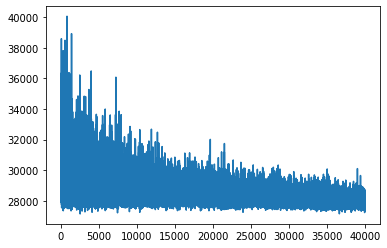

In [172]:
plt.plot(approx.hist)

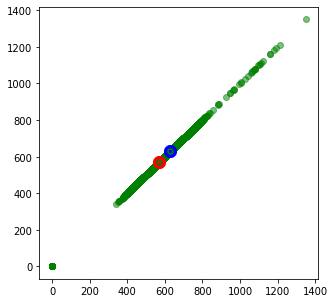

In [166]:
mu_0, mu_1 = scaler.inverse_transform(means["mu_0"]), scaler.inverse_transform(means["mu_1"])
data2 = scaler.inverse_transform(data[:, 0])

plt.figure(figsize=(5, 5))
plt.scatter(data2, data2, alpha=0.5, c="g")
#mu_0, mu_1 = means["mu_0"], means["mu_1"]
plt.scatter(mu_0[0], mu_0[1], c="r", lw=10, s=10)
plt.scatter(mu_1[0], mu_1[1], c="b", lw=10, s=10)
#plt.xlim(-6, 6)
#plt.ylim(-6, 6)


In [183]:
from sklearn.mixture import BayesianGaussianMixture
nr_comp = 2

BGM = BayesianGaussianMixture(n_components=nr_comp, verbose=1, n_init=5,
                              init_params='random', weight_concentration_prior_type='dirichlet_distribution',
                              covariance_type='full')
#BGM.mean_prior = [[2.3, 3.5, 0], [0,0,0]]
xy1 = df_input['temp'].values.reshape(-1,1)
BGM.fit(data_)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
Initialization converged: True


BayesianGaussianMixture(init_params='random', n_components=2, n_init=5,
                        verbose=1,
                        weight_concentration_prior_type='dirichlet_distribution')

In [184]:
"weights", BGM.weights_, "means", BGM.means_, "precision", BGM.precisions_

('weights',
 array([0.96907695, 0.03092305]),
 'means',
 array([[ 0.07937514],
        [-2.48353173]]),
 'precision',
 array([[[2.02014735]],
 
        [[0.09582892]]]))

In [195]:
scaler.inverse_transform(BGM.means_), scaler.inverse_transform(BGM.precisions_), BGM.precisions_

(array([[610.57775432],
        [320.58613039]]),
 array([[[830.17515498]],
 
        [[612.43949143]]]),
 array([[[2.02014735]],
 
        [[0.09582892]]]))

[[609.09271413]] [[612.0627945]]


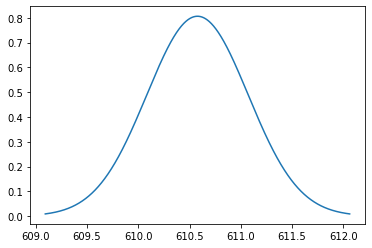

[[289.28034047]] [[351.89192031]]


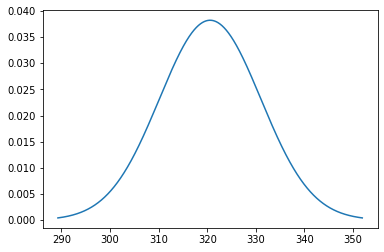

In [196]:
for i in [0,1]:
    mu = scaler.inverse_transform(BGM.means_[i])
    sigma = 1/BGM.precisions_[i]
    print (mu - 3*sigma, mu + 3*sigma)
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    x = np.arange(mu - 3*sigma, mu + 3*sigma, 0.0001)

    #print (x)
    y = sp.stats.norm.pdf(x, mu, sigma).reshape(-1,)
    #print (y)
    plt.plot(x, y)
    plt.show()

[[3.34388832e-16 2.23347388e-05]
 [3.37704421e-16 2.23403412e-05]
 [3.41052338e-16 2.23459433e-05]
 ...
 [3.18778419e-08 5.97941940e-06]
 [3.16810494e-08 5.97634364e-06]
 [3.14854212e-08 5.97326899e-06]]


Text(0, 0.5, '$p(x)$')

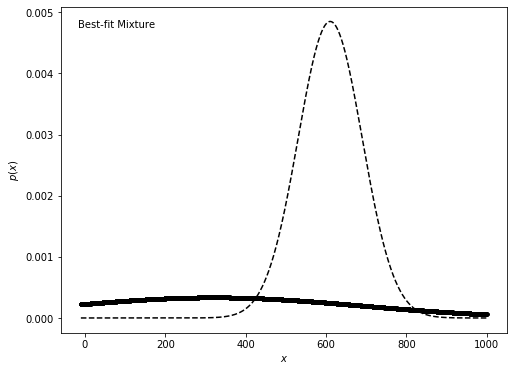

In [188]:
#  
# from https://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html
#   (full example shows how to select the model with lowest AIC)
#
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=False)
x = np.linspace(-10, 1000, 10000)
logprob = BGM.score_samples(x.reshape(-1, 1))
responsibilities = BGM.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
print (pdf_individual)

#ax[0,0] = fig.add_subplot(131)
#ax[0,0].hist(xy1, 50, density=True, histtype='stepfilled', alpha=0.4)
#ax[0,0].plot(x, pdf) #, '-k')
ax[0,0].plot(x, pdf_individual[:,0], '--k')
ax[0,0].plot(x, pdf_individual[:,1]*10, '.k')


ax[0,0].text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax[0,0].transAxes)
ax[0,0].set_xlabel('$x$')
ax[0,0].set_ylabel('$p(x)$')

ValueError: x and y must be the same size

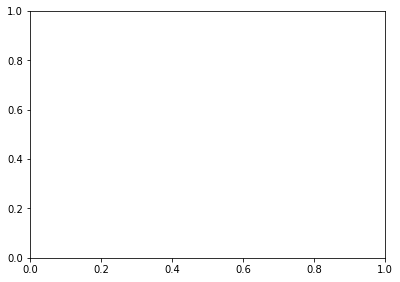

In [140]:
plt.figure(figsize=(14,10))
for i in range(nr_comp):
    plt.subplot(nr_comp,nr_comp,i+1)
    #plt.scatter(x1[idx11],y1[idx11],c=BGM.predict_proba(xy1[idx11])[:,i],cmap='viridis',marker='x')
    plt.scatter(xy1, BGM.predict_proba(xy1)[i],cmap='viridis',marker='x')

In [117]:
import theano.tensor as tt
data = df_input['temp'].values
ndata = data.size

model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet("p", a=np.array([1.0, 1.0]), shape=2)
    # ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))

    # cluster centers
    means = pm.Normal("means", mu=[0, 0], sigma=15, shape=2)
    # break symmetry
    '''
    order_means_potential = pm.Potential(
        "order_means_potential",
        tt.switch(means[1] - means[0] < 0, -np.inf, 0)
        + tt.switch(means[2] - means[1] < 0, -np.inf, 0),
    )
    '''

    # measurement error
    sd = pm.Uniform("sd", lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical("category", p=p, shape=ndata)

    # likelihood for each observed value
    points = pm.Normal("obs", mu=means[category], sigma=sd, observed=data)

In [131]:
map_estimate = pm.find_MAP(model=model) #, method="powell")

In [132]:
map_estimate

{'p_stickbreaking__': array([-105.5628586]),
 'means': array([581.63975217,   0.        ]),
 'sd_interval__': array(219.90625439),
 'category': array([0, 0, 0, ..., 0, 0, 0]),
 'p': array([2.22044605e-16, 1.00000000e+00]),
 'sd': array(20.)}

In [130]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category], proposal = 'uniform')
    tr = pm.sample(10000, step=[step1, step2], tune=2000)

2021-02-07T17:38:47.098 INFO pymc3.sample Multiprocess sampling (4 chains in 4 jobs)
2021-02-07T17:38:47.099 INFO pymc3._print_step_hierarchy CompoundStep
2021-02-07T17:38:47.099 INFO pymc3._print_step_hierarchy >CompoundStep
2021-02-07T17:38:47.099 INFO pymc3._print_step_hierarchy >>Metropolis: [means]
2021-02-07T17:38:47.100 INFO pymc3._print_step_hierarchy >>Metropolis: [sd]
2021-02-07T17:38:47.100 INFO pymc3._print_step_hierarchy >>Metropolis: [p]
2021-02-07T17:38:47.100 INFO pymc3._print_step_hierarchy >CategoricalGibbsMetropolis: [category]


ValueError: Not enough samples to build a trace.

/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


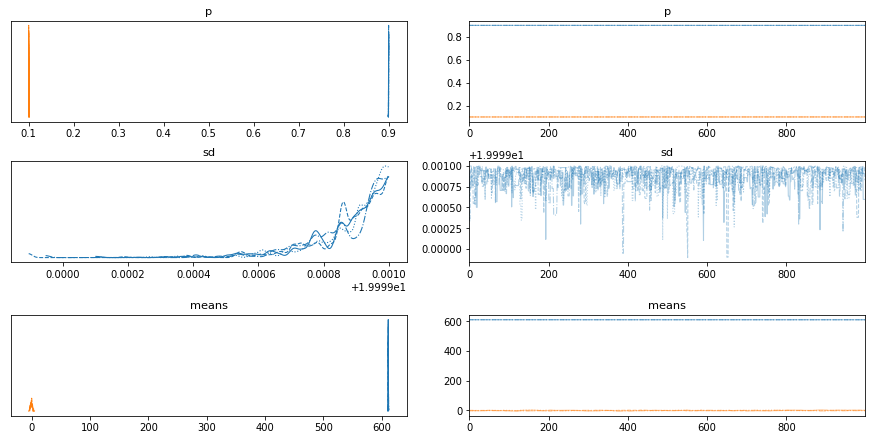

In [121]:
pm.traceplot(tr, var_names=["p", "sd", "means"]);

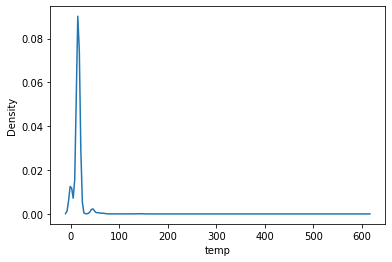

In [104]:
sns.kdeplot(data=df_input2['temp'])

<Figure size 1728x720 with 0 Axes>

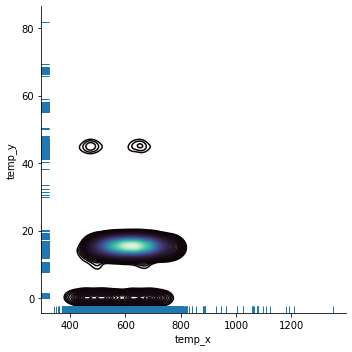

In [89]:
df_merge2 = df_merge.copy()
df_merge2 = df_merge2[df_merge2['temp_y'] < 100]

import seaborn as sns
plt.figure(figsize=(24, 10))
gx = sns.displot(df_merge2[['temp_x','temp_y']], x='temp_x', y='temp_y', 
                 levels=100, kind="kde", cmap="mako", rug=True)
    
#gx.set_titles('KDE for' + df_clean.index.levels[0].values[0])